In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import svm, datasets
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#------------------------------------------------------------------------------
# 1- Split into a training set and a test set using a ShuffleSplit
#    + doing that in parallel for the differrent features to test
#------------------------------------------------------------------------------

from sklearn.model_selection import ShuffleSplit
def split_data(X, y, test_size=.25, train_size=None) :
    

    rs = ShuffleSplit(n_splits=1, test_size=test_size, train_size=train_size, random_state=0)
    for index_train, index_test in rs.split(y): pass

    X_train, X_test = {}, {}
    X_train, X_test = X[index_train, :], X[index_test, :]
    y_train, y_test =  y[index_train].copy(), y[index_test].copy()

    print('nb_trial_train : %s, nb_trial_test : %s'%(y_train.shape[0], y_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [27]:
 #------------------------------------------------------------------------------
# 4- Train a SVM classification model
#------------------------------------------------------------------------------

# When training an SVM with the Radial Basis Function (RBF) kernel,
#    two parameters must be considered: C and gamma.

#The parameter C, common to all SVM kernels, trades off misclassification
#of training examples against simplicity of the decision surface.
#    A low C makes the decision surface smooth,
#    while a high C aims at classifying all training examples correctly.

#gamma defines how much influence a single training example has.
#    The larger gamma is, the closer other examples must be to be affected.


from sklearn.grid_search import GridSearchCV # see http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.svm import SVC

def Train_SVM(X_train, y_train, size_c_gamma=32) :


    C_range = np.logspace(-5, 10., size_c_gamma, base=2.)
    gamma_range = np.logspace(-14, 3, size_c_gamma, base=2.)

    

    param_grid = [{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': gamma_range, 'C': C_range},
                  {'kernel': ['linear'], 'C': C_range}]

    
    grid = GridSearchCV(SVC(verbose=False, tol=1e-3, max_iter = -1, ),
                        param_grid, verbose=1, scoring='f1_weighted', n_jobs=1,) #cv=50, 

    X_train_ = np.zeros((len(X_train), 0))
    X_train_ = np.hstack((X_train_, X_train))
    grid.fit(X_train, y_train.ravel())


    # plot the scores of the grid
    score_dict = grid.grid_scores_ # grid_scores_ contains parameter settings and scores
    
    scores_mean, scores_std ={}, {}
    for params, mean_score, scores in score_dict:
        try :
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)
        except:
            scores_mean[params['kernel']] = []
            scores_std[params['kernel']] = []
            scores_mean[params['kernel']].append(scores.mean())
            scores_std[params['kernel']].append(scores.std()/2)


    # draw heatmap of accuracy as a function of gamma and C
    fig1, ax1 = plt.subplots(1,4,figsize=(5*4,5))

    
    for x, k in enumerate(['rbf', 'poly', 'sigmoid']) :
        scores = np.array(scores_mean[k]).reshape((gamma_range.shape[0], C_range.shape[0]))
        im = ax1[x].imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
        ax1[x].set_xlabel('gamma')
        ax1[x].set_ylabel('C')
        #ax.set_colorbar()
        ax1[x].set_title(k)
        fig1.colorbar(im, ax=ax1[x], pad=0.01, fraction=.047)
    
    scores = np.array(scores_mean['linear']) #.reshape((gamma_range.shape[0], C_range.shape[0]))
    #im = ax1.imshow(scores, interpolation='nearest', cmap=plt.cm.gray)
    
    ax1[-1].set_title('linear')
    ax1[-1].plot(C_range, scores, 'k')
    ax1[-1].set_xlabel('C')
    ax1[-1].set_ylabel('Score')
    
    fig1.tight_layout()
    plt.show()
    
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    return grid

In [28]:
#------------------------------------------------------------------------------
# 5- Quantitative evaluation of the model quality on the test set
#------------------------------------------------------------------------------
def Quantitative_evaluation(grid, X_test, classes) :

    import itertools
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    
    y_pred = grid.predict(X_test)
    # see https://en.wikipedia.org/wiki/F1_score
    fone_score = np.array(metrics.f1_score(y_test, y_pred, average=None)).mean()
    
    print("Predicting the category names on the testing set")
    print('\nclassification_report on test \n', classification_report(y_test, y_pred, target_names=classes))
    
    
    cm = confusion_matrix(y_test, y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.imshow(norm_cm, interpolation='nearest', cmap=plt.cm.Reds)
    
    ax.set_title('Confusion matrix\n(fone_score on test => Accuracy = %0.2f)' % (fone_score))
    fig.colorbar(im, ax=ax, pad=0.01, fraction=.047)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    thresh = norm_cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 'nb_trial = %s\n\n(%.0f %%)'%(cm[i, j], norm_cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        if i==j :
            ax.text(j, i+0.2, 'f1_score = %.2f'%(metrics.f1_score(y_test, y_pred, average=None)[i]),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")
        

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    return y_pred

In [29]:
from sklearn import metrics

def fig_final(grid, X_train, y_train, X_test, y_test, y_pred, var) :
    
    #nb = int((X_train.shape[1]-1)*(X_train.shape[1]-(X_train.shape[1]/2)))
    
    #fig, ax = plt.subplots(1,nb,figsize=(10*(nb),10/1.68))

    #x = 0
    for x1 in range(X_train.shape[1]) :

        nb = len(range(x1, X_train.shape[1]-1))
        fig, axs = plt.subplots(1,nb,figsize=(10*(nb),10/1.68))
        
        x=0
        for x2 in range(x1, X_train.shape[1]) :
            if x2 != x1 :
                
                if nb==1: ax = axs
                else : ax =axs[x]
                
                xlim = [min(X_train[:, x1]), max(X_train[:, x1])]
                ylim = [min(X_train[:, x2]), max(X_train[:, x2])]
                
                # create grid to evaluate model
                a = 1
                xx = np.linspace(xlim[0]-a, xlim[1]+a, len(X_train[:, x1]))
                yy = np.linspace(ylim[0]-a, ylim[1]+a, len(X_train[:, x2]))
                YY, XX = np.meshgrid(yy, xx)
                xy = np.vstack([XX.ravel(), YY.ravel()]).T

                clf = SVC(kernel=grid.best_params_['kernel'], C=grid.best_params_['C'],
                          gamma=grid.best_params_['gamma'])
                
                X_fit = [[],[]]
                X_fit[0], X_fit[1] = X_train[:, x1], X_train[:, x2]
                X_fit = np.array(X_fit).transpose()
                
                clf.fit(X_fit, y_train)
                Z = clf.decision_function(xy).reshape(XX.shape)



                # plot decision boundary and margins
                ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
                ax.contourf(XX, YY, Z, cmap=plt.cm.RdGy, alpha=0.5)

                # plot support vectors
                ax.scatter(X_train[:, x1], X_train[:, x2], c=y_train, s=200, cmap=plt.cm.RdGy, alpha=0.3)
                #ax[x].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=150, linewidth=1, facecolors='none', edgecolors='k')

                #X_test_2d = X_test[:, x_:x_+2]:
                
                X_t = [[],[]]
                X_t[0], X_t[1] = X_test[:, x1], X_test[:, x2]
                X_t = np.array(X_t).transpose()
                y_pred2 = clf.predict(X_t)

                print('%s-%s'%(var[x1], var[x2]), '\tscore grid :', clf.score(X_t, y_pred), '\tscore clf :',
                      clf.score(X_t, y_pred2))
                print('\t\tf1_score grid: \t%.2f'%np.array(metrics.f1_score(y_test, y_pred, average=None)).mean(),
                      '\tf1_score clf: %.2f'%np.array(metrics.f1_score(y_test, y_pred2, average=None)).mean(),
                     end='\n\n')


                ax.scatter(X_test[:, x1], X_test[:, x2], c=y_pred, s=40, cmap=plt.cm.RdGy)

                for a in range(len(y_test)) :
                    if y_test[a]!=y_pred[a] :
                        if y_test[a] == 1 : c='k'
                        else : c='r'
                        ax.scatter(X_test[a, x1], X_test[a, x2], facecolors='none', s=60, lw=2,
                                   edgecolors=c)

                ax.set_xlabel('%s'%var[x1])
                ax.set_ylabel('%s'%var[x2])
                x=x+1

        plt.show()

# Data

In [30]:
import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637',
        '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250',
        '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313',
        '2017-11-08_150410','2017-11-17_172706']
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

In [31]:
X, y, var = [], [], []
a = 0
for x in [4] : #in range(len(sujet)) :

    print(sujet[x])
    print(Delete_list_trials[sujet[x]], Bad_Fit[sujet[x]])
    #-------------------------------------------------------------------------
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier :
        param_exp = pickle.load(fichier, encoding='latin1')
    A = ANEMO(param_exp)
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/goodness_of_fit_'+ sujet[x] +'.pkl')
    with open(file, 'rb') as fichier :
        goodness_of_fit = pickle.load(fichier, encoding='latin1')
    #-------------------------------------------------------------------------

    for block in [0] :# in range(N_blocks) :
        for trial in range(N_trials) :

            if trial in Delete_list_trials[sujet[x]][block] : y.append(1)
            elif trial in Bad_Fit[sujet[x]][block] : y.append(1)
            else : y.append(0)

            if a==0 :
                var.append('nb_nan')
                X.append([])
                for key in goodness_of_fit.keys() :
                    if key!='residual' :
                        var.append(key)
                        X.append([])
                a=1
            
            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)
            velocity_NAN = A.velocity_NAN(**arg)[0]

            nb_nan = [x for x in velocity_NAN[arg.StimulusOf-arg.t_0:] if str(x)=='nan']
            X[0].append(len(nb_nan))
            
            k = 1
            for key in goodness_of_fit.keys() :
                if key!='residual' :
                    X[k].append(goodness_of_fit[key][block][trial])
                    k=k+1

FM
[[14, 29, 35, 48, 50, 58, 59, 60, 71, 73, 77, 80, 104, 157, 161, 167, 173, 174, 175, 178, 191, 198], [12, 31, 64, 68, 69, 70, 96, 98, 121, 129, 194], [100, 158, 177]] [[29, 73, 104], [12, 70, 76], [78, 79, 116]]


In [32]:
classes = ['good', 'Bad']

X1 = np.array(X)
y1 = np.array(y)
X1 = X1.transpose()
print(X1.shape)

(200, 6)


In [33]:
X_train, X_test, y_train, y_test = split_data(X1, y1, test_size=.8, train_size=None)
print(y_train[y_train>0])

nb_trial_train : 40, nb_trial_test : 160
[1 1 1 1]


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   37.5s finished


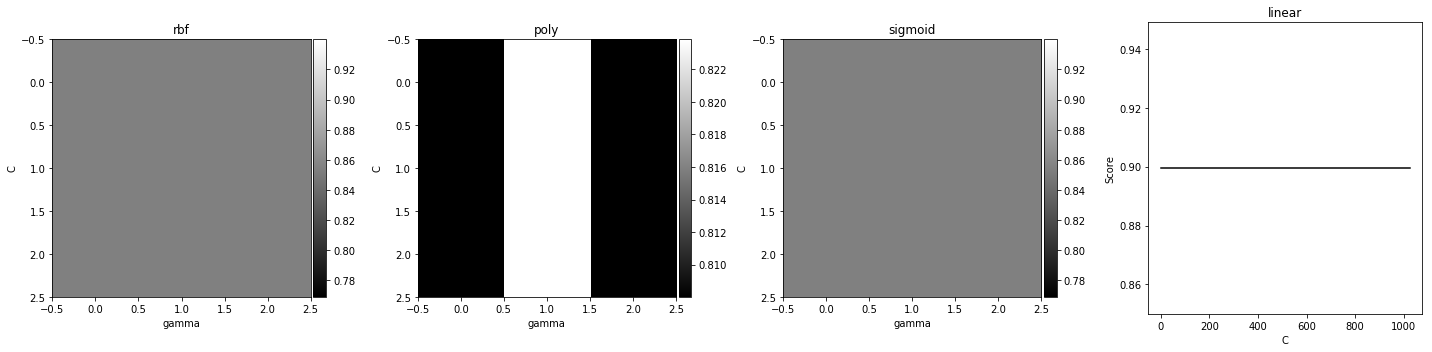

The best parameters are {'C': 0.03125, 'kernel': 'linear'} with a score of 0.90


In [36]:
grid = Train_SVM(X_train, y_train, size_c_gamma=3)

Predicting the category names on the testing set

classification_report on test 
              precision    recall  f1-score   support

       good       0.90      0.93      0.92       142
        Bad       0.29      0.22      0.25        18

avg / total       0.83      0.85      0.84       160



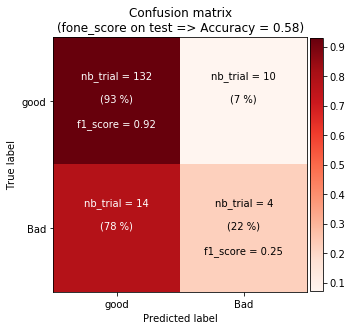

In [37]:
y_pred = Quantitative_evaluation(grid, X_test, classes)

KeyError: 'gamma'

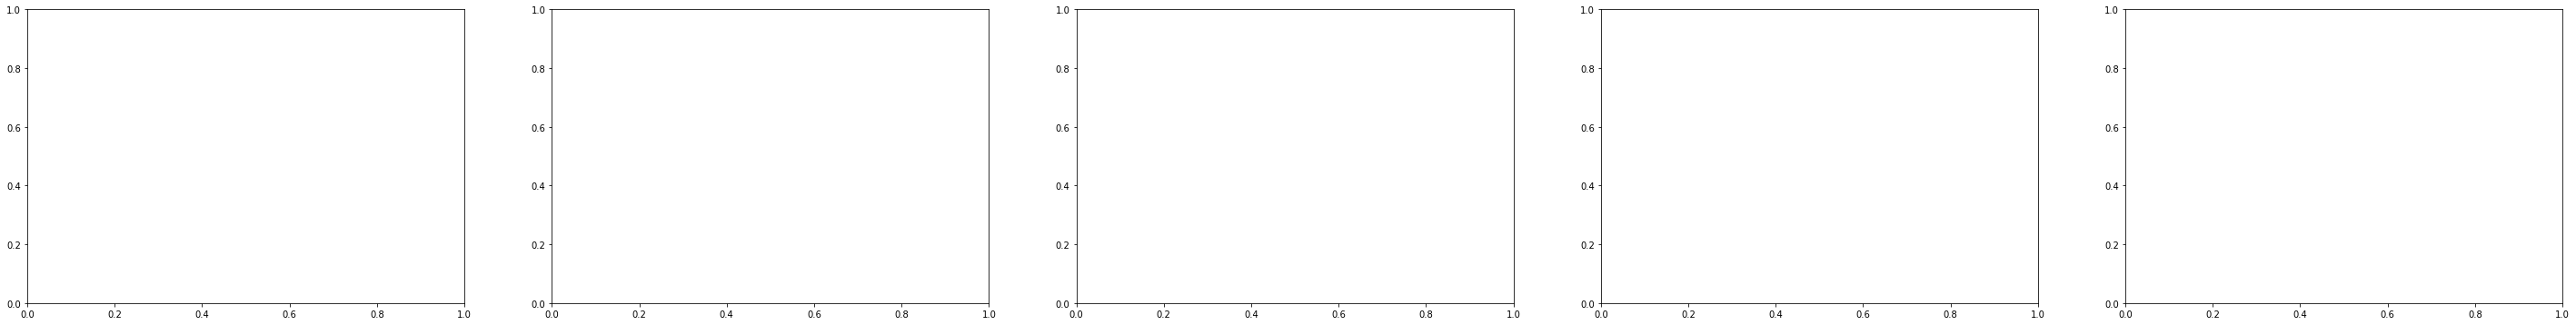

In [38]:
fig_final(grid, X_train, y_train, X_test, y_test, y_pred, var) 